In [113]:
import os 
import tqdm
import librosa
import numpy as np
from matplotlib import pyplot as plt
import skfda
import math 

from scipy.optimize import minimize


In [114]:
our_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs")
paper_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper")

In [115]:
dic_1 = {file:{'Label':None,
             'Author':None,
             'MFCC':None} for file in our_files}

dic_2 = {file:{'Label':None,
               'MFCC':None} for file in paper_files}

In [141]:
for file in tqdm.tqdm(our_files):
    path = 'C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs/' + file
    audio, _ = librosa.load(path, sr=None)  
    dic_1[file]['MFCC'] = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=20, dct_type=2, n_fft=1012, hop_length=256, norm='ortho')
    dic_1[file]['Author'] = file.split('_')[2]
    dic_1[file]['Label']  = float(file.split('_')[3][:-4])

for file in tqdm.tqdm(paper_files):
    path = 'C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper/' + file
    audio, _ = librosa.load(path, sr=None)
    dic_2[file]['MFCC'] = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=20, dct_type=2, n_fft=1012, hop_length=256, norm='ortho')
    dic_2[file]['Label'] = float(file.split('_')[3][:-4])

100%|██████████| 333/333 [00:05<00:00, 66.02it/s]


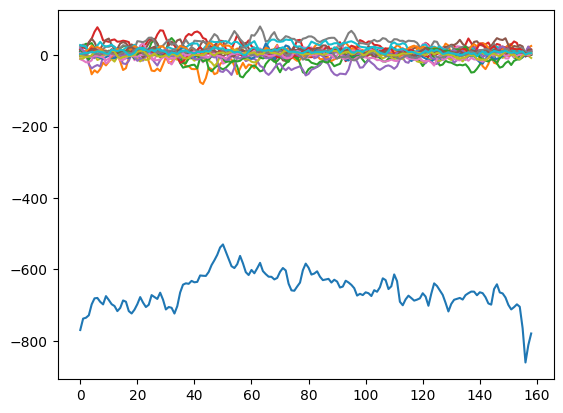

In [142]:
keys = list(dic_2.keys())
plt.plot(dic_2[keys[2]]['MFCC'].transpose())

In [143]:
# Functional tool kit

basis = skfda.representation.basis.Fourier(n_basis=40)

def FDA_generator(array):
    points = np.linspace(0,1,len(array))
    fd_obj = skfda.FDataGrid(data_matrix=[array],
                             grid_points=points)
    return fd_obj

# First transform pipeline: retrieve eGFC from the extracted features

def processing(matrix, basis):
    output = np.zeros((np.shape(matrix)[0],basis.n_basis))
    for i in range(0,np.shape(matrix)[0]):
        fda_obj = FDA_generator(matrix[i,])
        output[i,:] = fda_obj.to_basis(basis).coefficients
    return output

def vec_processing(array,basis):
    fda_obj = FDA_generator(array)
    return fda_obj.to_basis(basis).coefficients

In [144]:
design_tensor = np.zeros((20,41,len(dic_2.values())))

for i in tqdm.tqdm(range(len(dic_2.keys()))):
    key = list(dic_2.keys())[i]
    design_tensor[:,:,i] = processing(dic_2[key]['MFCC'],basis)

y_true = np.array([dic_2[key]['Label'] for key in dic_2.keys()])

100%|██████████| 333/333 [00:14<00:00, 22.72it/s]


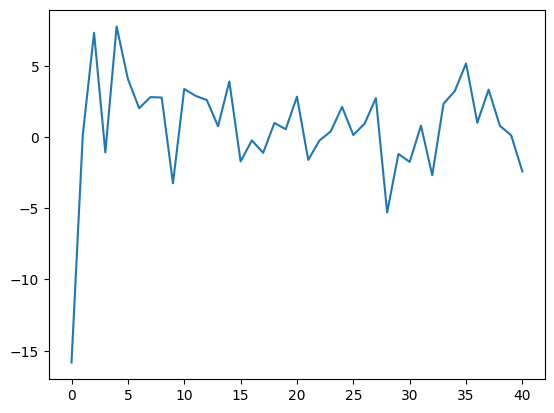

In [146]:
plt.plot(design_tensor[2,:,0])

In [147]:
design_tensor.shape

(20, 41, 333)

In [150]:
# Non-parametric regression on a vectorial functional space 

def K(t):
    return(0.5*np.exp(-0.5*(t**2)))

def L2(x1,x2):
    return np.linalg.norm(x1-x2)

def mNorm(X):
    return np.sqrt(np.max(np.abs(np.linalg.eigvals(np.matmul(np.transpose(X),X)))))

def mDist(X1,X2):
    return mNorm(X1-X2)

def VF_dist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros((L,L))

    for i in range(0,L):
        for k in range(0,L):
            D[i,k] = L2(X1[i,:],X2[i,:])

    return mNorm(D)

def supDist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.max(D)

def weightedCompWiseDist(X1,X2,omega):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.sum(D*omega)
   
def distDist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.linalg.norm(D)

def kNN_estimator(x,X,Y,K):
    distances = np.zeros(len(Y))
    for i in range(len(Y)):
        distances[i] = mDist(x,X[:,:,i])
    Y = Y[np.argsort(distances)]
    return np.mean(Y[0:K])/K

def KR_estimator(x,X,Y,omega):
    weights = np.ones(len(Y))
    for i in range(len(Y)):
        weights[i] = K(weightedCompWiseDist(x,X[:,:,i],omega))
    return np.sum(weights*Y)/np.sum(weights)  

# Validation functions

def LOOCV(X,Y,K):
    err = np.zeros(len(Y))
    for i in range(0,len(Y)):
        x = X[:,:,i]
        y = Y[i]
        _X = X[:,:,[j for j in range(0,len(Y)) if j != i]]
        _Y = Y[[j for j in range(0,len(Y)) if j != i]]
        pred = KR_estimator(x,_X,_Y,K)
        err[i] = (pred-y)**2
        #print(y,pred)
    return (np.mean(err))

def LOOCV_fit(X,Y,grid):
    errs = np.zeros(len(grid))
    for p in range(len(grid)):
        errs[p] = LOOCV(X,Y,grid[p])  
    return grid[np.argmin(errs)]

# Minimization problem objective function 

def objective(params):
    omega = params[0:20]
    output = 0
    for i in range(len(y_true)):
        x = design_tensor[:,:,i]
        y = y_true[i]
        _X = design_tensor[:,:,[j for j in range(0,len(y_true)) if j != i]]
        _Y = y_true[[j for j in range(0,len(y_true)) if j != i]]
        pred = KR_estimator(x,_X,_Y,omega)
        output += (pred-y)**2
    return np.sqrt(output/len(y_true))

def seqGridSearching(X,Y,grid,P):
    params = np.array([0.1 for j in range(P)])
    for j in range(P):
        errs = np.zeros(len(grid))
        for p in range(len(grid)):
            params[j] = grid[p]
            errs[p] = LOOCV(X,Y,params)
        params[j] = grid[np.argmin(errs)]
    return params

In [151]:
minimize(objective, x0 = np.array([0.1 for j in range(20)]), options={'maxiter':50}, method='Nelder-Mead')

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 19.21410479191212
             x: [ 8.631e-02  1.077e-01 ...  9.985e-02  9.693e-02]
           nit: 50
          nfev: 74
 final_simplex: (array([[ 8.631e-02,  1.077e-01, ...,  9.985e-02,
                         9.693e-02],
                       [ 8.222e-02,  1.042e-01, ...,  1.018e-01,
                         9.858e-02],
                       ...,
                       [ 9.040e-02,  1.029e-01, ...,  1.049e-01,
                         9.957e-02],
                       [ 9.086e-02,  1.029e-01, ...,  9.915e-02,
                         9.960e-02]]), array([ 1.921e+01,  1.926e+01, ...,  1.943e+01,  1.944e+01]))

In [84]:
# Tensorizing the operations

def vec_L2(X1,X2):
    return np.linalg.norm(np.sum([X1,-X2],axis=0),axis=1)

def vec_weightedCompWiseDist(X1,X2,omega):
    return vec_L2(X1,X2)*omega

def vec_LOOCV(X,Y,h,omega):
    mask = np.array([[j for j in range(0,len(Y)) if j != i] 
                        for i in range(0,len(Y))])
    
    LOO_design_tensor = X[:,:,mask]
    LOO_y_true = Y[mask]

    dist_tens = vec_L2(np.repeat(X[:,:,:,np.newaxis], 332, 3),LOO_design_tensor)*omega[:,:,np.newaxis]/h
    weights = K(dist_tens)

In [139]:
mask = np.array([[j for j in range(0,len(y_true)) if j != i] for i in range(0,len(y_true))])

LOO_design_tensor = design_tensor[:,:,mask]
LOO_y_true = y_true[mask]